# Empirical Methods Project

Francois Chevalier 

Friday 6th December 2024

1. Constant Proportion Portfolio Insurance (CPPI) Simulation
2. Structured Covariance Matrix Estimation
3. Put-Call Parity in Bitcoin Options

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import t

# 1. Constant Proportion portfolio Insurance Simulation

Inputs

In [2]:
S0 = 100
mu = 0.1
sigma = 0.2
r = 0.02
A0 = 100

1.1 Simulate 10,000 paths over 3 years for the stock index with a monthly time step.

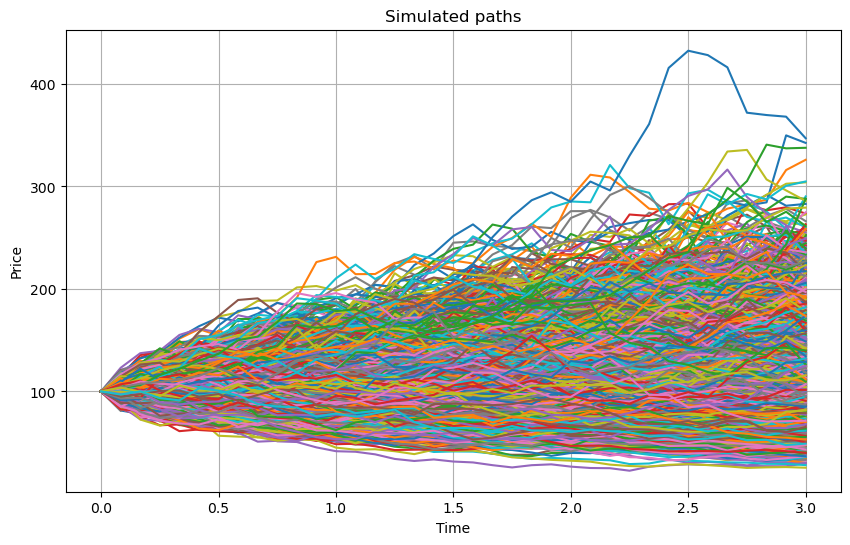

In [30]:
nb_paths = 10000
nb_years = 3
nb_steps = 12*nb_years 
paths = np.zeros((nb_steps + 1, nb_paths))
dt = 1/12
paths[0] = S0
for i in range(len(paths[0])):
    for t in range(1, len(paths)):
        paths[t][i] = paths[t-1][i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1))

dates = np.linspace(0, nb_years, nb_steps + 1)
plt.figure(figsize=(10, 6))
for i in range(len(paths[0])):
    plt.plot(dates, paths[:, i])

plt.title('Simulated paths')
plt.xlabel('Time')
plt.grid()
plt.ylabel('Price')
plt.show()


1.2 Setting the multiplier equal to 3, simulate 10,000 values for the final wealth, 𝐴3 years, assuming
monthly rebalancing.

In [4]:
m = 3
floor = A0 * np.exp(-r * (nb_years - dates))
w = np.zeros((len(dates), nb_paths))
A = np.zeros((len(dates), nb_paths))
returns = np.zeros((len(dates), nb_paths))
A[0] = A0
returns[0] = 0
for i in range(len(paths[0])):
    for t in range(1, len(dates)):

            w[t-1, i] = m * (A[t-1, i] - floor[t-1]) / A[t-1, i]
            returns[t-1, i] = w[t-1, i] * (paths[t, i] - paths[t-1, i]) / paths[t-1, i] + r * (1-w[t-1, i]) * (dates[t] - dates[t-1])
            A[t, i] = A[t-1, i] * (1 + returns[t-1, i])



1.3 Make a histogram plot of the distribution of the gross return on the portfolio, 𝐴3 years/𝐴0.

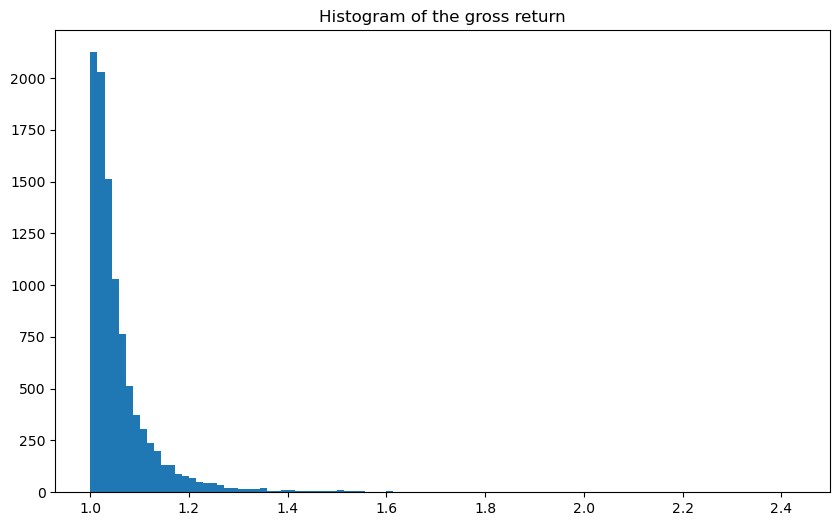

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(A[-1]/A[0], bins=100)
plt.title('Histogram of the gross return')
plt.show()

The histogram of the gross return exhibits a right-skewed distribution (positively skewed). Most of the data points are concentrated near 1, indicating that the majority of returns are close to their baseline value. The tail extends to the right, showing a smaller number of higher gross return values, which implies a presence of extreme positive outcomes.

The law that seems to fit the shape of this distribution is the exponential law.

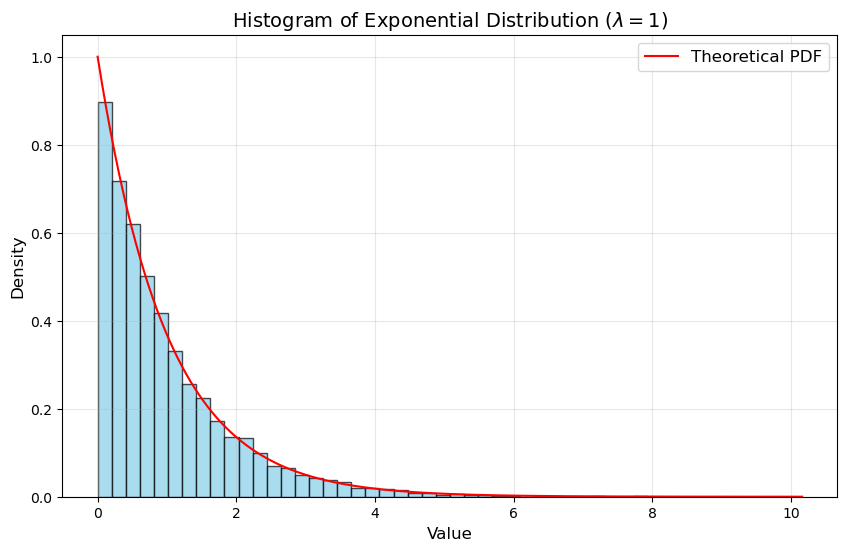

In [31]:
# Parameters
lambda_param = 1  # Parameter of the exponential distribution
sample_size = 10000  # Number of samples

# Generate random samples from the exponential distribution
samples = np.random.exponential(scale=1/lambda_param, size=sample_size)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Overlay the theoretical PDF
x = np.linspace(0, max(samples), 1000)
pdf = lambda_param * np.exp(-lambda_param * x)
plt.plot(x, pdf, 'r-', label='Theoretical PDF')

# Add labels and title
plt.title("Histogram of Exponential Distribution ($\lambda = 1$)", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

1.4 For every multiplier 1, 3 and 5, report the minimum, the mean and the 25th, 50th and 75th
percentiles of the distribution of the gross return.

In [6]:
m_values = [1, 3, 5]
for m in m_values:
    w = np.zeros((len(dates), nb_paths))
    A = np.zeros((len(dates), nb_paths))
    returns = np.zeros((len(dates), nb_paths))
    A[0] = A0
    returns[0] = 0
    for i in range(len(paths[0])):
        for t in range(1, len(dates)):

                w[t-1, i] = m * (A[t-1, i] - floor[t-1]) / A[t-1, i]
                returns[t-1, i] = w[t-1, i] * (paths[t, i] - paths[t-1, i]) / paths[t-1, i] + r * (1-w[t-1, i]) * (dates[t] - dates[t-1])
                A[t, i] = A[t-1, i] * (1 + returns[t-1, i])
    print('-------------------------------------------------------')
    print('m =', m)
    print('Minimum of the gross return:', np.min(A[-1]/A[0]))
    print('Mean of the gross return:', np.mean(A[-1]/A[0]))
    print('25th percentile of the gross return:', np.percentile(A[-1]/A[0], 25))
    print('50th percentile of the gross return:', np.percentile(A[-1]/A[0], 50))
    print('75th percentile of the gross return:', np.percentile(A[-1]/A[0], 75))


-------------------------------------------------------
m = 1
Minimum of the gross return: 1.0161446081900116
Mean of the gross return: 1.061755250070084
25th percentile of the gross return: 1.0460499168286805
50th percentile of the gross return: 1.0583626176255883
75th percentile of the gross return: 1.0734167119331814
-------------------------------------------------------
m = 3
Minimum of the gross return: 1.0005604212930863
Mean of the gross return: 1.0613068222741378
25th percentile of the gross return: 1.0172466244897784
50th percentile of the gross return: 1.0361535471089116
75th percentile of the gross return: 1.0728927219614257
-------------------------------------------------------
m = 5
Minimum of the gross return: 0.9764591839861783
Mean of the gross return: 1.0591683405343608
25th percentile of the gross return: 1.0031139510427838
50th percentile of the gross return: 1.0122888778382295
75th percentile of the gross return: 1.0426166778644752


# 2. Structured Covariance Matrix Estimation

1. Explain why a low leverage or a high ENC correspond to a less concentrated portfolio.

A low leverage or high ENC corresponds to a less concentrated portfolio because they both indicate that the portfolio is spread more evenly across its constituents. Leverage measures the extent of negative weights (short positions), and low leverage suggests a more balanced exposure. ENC is the reciprocal of the sum of squared weights, so a high ENC means the portfolio has weights spread across many assets. In contrast, a low ENC indicates concentration in a few assets. Therefore, a portfolio with low leverage and high ENC is more diversified and less reliant on any single asset.

2. Import the monthly portfolio returns.

In [7]:
returns = pd.read_csv('sorted_portfolios.csv', skiprows=15, sep=';')
returns.index = returns.iloc[:, 0]
returns.drop(returns.columns[0], axis=1, inplace=True)
returns.rename_axis("Date", inplace=True)
returns.head(5)

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
31/07/1926,-99.99,12.3656,-99.99,-20.6349,-6.4864,-4.7429,-4.8812,15.7276,-1.6398,-2.4470,...,3.3411,1.1820,19.0161,1.4227,1.9459,2.4834,2.7332,3.5356,0.8576,-99.99
31/08/1926,-99.99,2.9904,-99.99,8.0000,6.7495,-3.5639,-4.1188,-1.6529,-5.3824,9.6015,...,0.2379,3.9628,8.5675,3.0099,1.1427,3.0263,6.7182,3.2370,11.2245,-99.99
30/09/1926,-99.99,-18.5830,-99.99,-3.7037,-5.0512,-2.1739,-4.5714,-10.6100,0.4919,7.7448,...,-0.3920,-1.9836,10.7849,0.8073,-0.9185,1.0889,-0.5241,-0.8665,-1.0703,-99.99
31/10/1926,-99.99,-4.1369,-99.99,-11.5385,-5.3996,-17.7778,3.5554,-9.2233,-9.1593,-1.7461,...,-4.3200,-0.6480,-6.6205,-0.5337,-1.5745,-1.9202,-5.5678,-1.8602,-3.9246,-99.99
30/11/1926,-99.99,-8.2589,-99.99,34.7826,1.2296,0.2027,-4.8789,-3.2010,-1.8459,-2.5421,...,6.9978,-0.0541,0.4585,2.9192,1.1447,0.8811,3.9514,2.3695,3.2680,-99.99


3. Eliminate from the investment universe the portfolio that have at least one missing return
(represented as -99.99 in the data) between January 1970 and the sample end. How many
portfolios does the universe contain?

In [8]:
print('End of the the investment- period: ', returns.index[-1] )

End of the the investment- period:  30/09/2024


In [9]:
columns_with_missing = returns.loc['31/01/1970':].isin([-99.99]).any()
columns_with_missing = columns_with_missing[columns_with_missing].index.tolist()
print(f"Columns with at least one missing value: {columns_with_missing}")

Columns with at least one missing value: ['ME7 BM10', 'ME9 BM10', 'ME10 BM8', 'ME10 BM9', 'BIG HiBM']


In [10]:
returns.drop(columns=columns_with_missing, inplace=True)
returns.shape[1]

95

The universe contains 95 portfolios

In [11]:
returns = returns.loc['31/01/1970':]

4. Calculate the constant correlation covariance matrix over the entire sample.

In [12]:
correlation_matrix = returns.corr()
nb_correlations = int(returns.shape[1] * (returns.shape[1] + 1) / 2 - returns.shape[1])
correlations_between_assets = np.zeros(nb_correlations)
index = 0
for i in range(returns.shape[1]):
    for j in range(i+1, returns.shape[1]):
        correlations_between_assets[index] = correlation_matrix.iloc[i, j]
        index += 1

print('Number of correlations :', len(correlations_between_assets))
print('Mean of the correlations :', np.mean(correlations_between_assets))

R = np.zeros((returns.shape[1], returns.shape[1]))
for i in range(returns.shape[1]):
    for j in range(returns.shape[1]):
        if i != j:
            R[i, j] = np.mean(correlations_between_assets)
        else:
            R[i, j] = 1
print('Constant correlation matrix over the entire sample:')
print(R)
V = np.diag(np.diag(returns.cov()))
V = np.sqrt(V)
constant_correlation_covariance_matrix = V @ R @ V
print('Constant correlation covariance matrix over the entire sample:')
pd.DataFrame(constant_correlation_covariance_matrix, index=returns.columns, columns=returns.columns)

Number of correlations : 4465
Mean of the correlations : 0.745616242423775
Constant correlation matrix over the entire sample:
[[1.         0.74561624 0.74561624 ... 0.74561624 0.74561624 0.74561624]
 [0.74561624 1.         0.74561624 ... 0.74561624 0.74561624 0.74561624]
 [0.74561624 0.74561624 1.         ... 0.74561624 0.74561624 0.74561624]
 ...
 [0.74561624 0.74561624 0.74561624 ... 1.         0.74561624 0.74561624]
 [0.74561624 0.74561624 0.74561624 ... 0.74561624 1.         0.74561624]
 [0.74561624 0.74561624 0.74561624 ... 0.74561624 0.74561624 1.        ]]
Constant correlation covariance matrix over the entire sample:


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME9 BM7,ME9 BM8,ME9 BM9,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
SMALL LoBM,73.354892,51.729660,51.312551,45.593204,43.953205,40.291908,39.399282,37.609779,37.038335,42.023486,...,32.679491,32.568142,37.197270,32.181374,29.906496,30.098532,30.963044,29.928000,32.910540,33.716173
ME1 BM2,51.729660,65.617464,48.530950,43.121643,41.570546,38.107724,37.263486,35.570990,35.030524,39.745436,...,30.907969,30.802656,35.180844,30.436854,28.285295,28.466921,29.284569,28.305634,31.126492,31.888453
ME1 BM3,51.312551,48.530950,64.563552,42.773943,41.235353,37.800453,36.963022,35.284173,34.748065,39.424959,...,30.658751,30.554287,34.897172,30.191435,28.057224,28.237385,29.048441,28.077399,30.875512,31.631329
ME1 BM4,45.593204,43.121643,42.773943,50.973028,36.639220,33.587177,32.843088,31.351365,30.875012,35.030615,...,27.241496,27.148676,31.007500,26.826268,24.929938,25.090019,25.810673,24.947864,27.434098,28.105670
ME1 BM5,43.953205,41.570546,41.235353,36.639220,47.371954,32.379038,31.661713,30.223648,29.764430,33.770554,...,26.261613,26.172131,29.892152,25.861320,24.033202,24.187524,24.882256,24.050483,26.447286,27.094702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ME10 BM3,30.098532,28.466921,28.237385,25.090019,24.187524,22.172706,21.681492,20.696726,20.382259,23.125597,...,17.983580,17.922304,20.469722,17.709465,16.457596,22.214207,17.039017,16.469430,18.110727,18.554068
ME10 BM4,30.963044,29.284569,29.048441,25.810673,24.882256,22.809567,22.304245,21.291193,20.967694,23.789828,...,18.500118,18.437082,21.057668,18.218130,16.930303,17.039017,23.508640,16.942477,18.630916,19.086992
ME10 BM5,29.928000,28.305634,28.077399,24.947864,24.050483,22.047081,21.558650,20.579463,20.266778,22.994573,...,17.881689,17.820761,20.353745,17.609128,16.364351,16.469430,16.942477,21.963199,18.008115,18.448945
ME10 BM6,32.910540,31.126492,30.875512,27.434098,26.447286,24.244230,23.707124,22.630354,22.286508,25.286146,...,19.663728,19.596727,22.382141,19.364003,17.995176,18.110727,18.630916,18.008115,26.558908,20.287514


5. On a rolling window of 120 months moving by a one-month step, calculate the following quantities:
* The sample covariance matrix of returns and the constant correlation covariance matrix;
* The composition of the global minimum variance portfolio with both covariance matrix
estimates;
* The leverage and the effective number of constituents of both portfolios.



In [13]:
window_size = 120
step_size = 1

def compute_constant_correlation_covariance_matrix(returns):
    correlation_matrix = returns.corr()
    nb_correlations = int(returns.shape[1] * (returns.shape[1] + 1) / 2 - returns.shape[1])
    correlations_between_assets = np.zeros(nb_correlations)
    index = 0
    for i in range(returns.shape[1]):
        for j in range(i+1, returns.shape[1]):
            correlations_between_assets[index] = correlation_matrix.iloc[i, j]
            index += 1

    R = np.zeros((returns.shape[1], returns.shape[1]))
    for i in range(returns.shape[1]):
        for j in range(returns.shape[1]):
            if i != j:
                R[i, j] = np.mean(correlations_between_assets)
            else:
                R[i, j] = 1
    V = np.diag(np.diag(returns.cov()))
    V = np.sqrt(V)
    constant_correlation_covariance_matrix = V @ R @ V
    return constant_correlation_covariance_matrix

def calculate_gmv_portfolio(cov_matrix):
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    ones = np.ones(len(cov_matrix))
    weights = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)
    return weights

def calculate_leverage(weights):
    sum = 0
    for w in weights:
        if w < 0:
            sum += w
    return -sum

def calculate_enc(weights):
    return 1 / np.sum(weights**2)


results = []
sample_weights = []
constant_corr_weights = []

for start in range(0, len(returns) - window_size + 1, step_size):
    end = start + window_size
    window_returns = returns.iloc[start:end]
    
    sample_cov_matrix = window_returns.cov().values
    constant_corr_cov_matrix = compute_constant_correlation_covariance_matrix(window_returns)
    
    gmv_sample_weights = calculate_gmv_portfolio(sample_cov_matrix)
    gmv_constant_corr_weights = calculate_gmv_portfolio(constant_corr_cov_matrix)
    
    leverage_sample = calculate_leverage(gmv_sample_weights)
    leverage_constant_corr = calculate_leverage(gmv_constant_corr_weights)
    
    enc_sample = calculate_enc(gmv_sample_weights)
    enc_constant_corr = calculate_enc(gmv_constant_corr_weights)
    
    results.append({
        'start_date': returns.index[start],
        'end_date': returns.index[end-1],
        'leverage_sample': leverage_sample,
        'leverage_constant_corr': leverage_constant_corr,
        'enc_sample': enc_sample,
        'enc_constant_corr': enc_constant_corr
    })
    sample_weights.append(gmv_sample_weights)
    constant_corr_weights.append(gmv_constant_corr_weights)


results_df = pd.DataFrame(results)
results_df.head()

,start_date,end_date,leverage_sample,leverage_constant_corr,enc_sample,enc_constant_corr
0,31/01/1970,31/12/1979,10.579838,1.809464,0.120724,2.645672
1,28/02/1970,31/01/1980,10.923452,1.774783,0.116178,2.714370
2,31/03/1970,29/02/1980,10.754087,1.762348,0.121201,2.730469
3,30/04/1970,31/03/1980,11.189966,1.758736,0.113423,2.722215
4,31/05/1970,30/04/1980,9.557211,1.785690,0.134910,2.658448


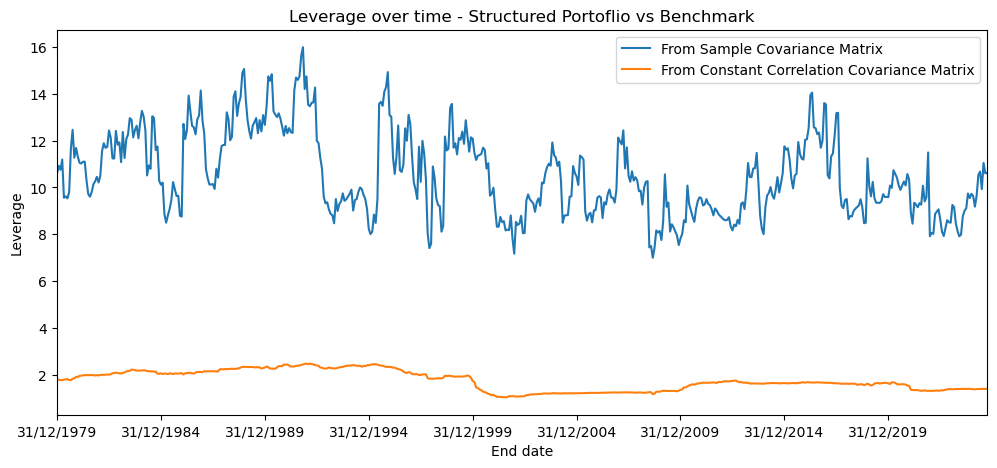

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(results_df['end_date'], results_df['leverage_sample'], label='From Sample Covariance Matrix')
plt.plot(results_df['end_date'], results_df['leverage_constant_corr'], label='From Constant Correlation Covariance Matrix')
plt.legend()
plt.xlabel('End date')
plt.ylabel('Leverage')
plt.title('Leverage over time - Structured Portoflio vs Benchmark')
plt.xlim(results_df['end_date'].iloc[0], results_df['end_date'].iloc[-1])
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # Show only 10 ticks on x-axis
plt.show()

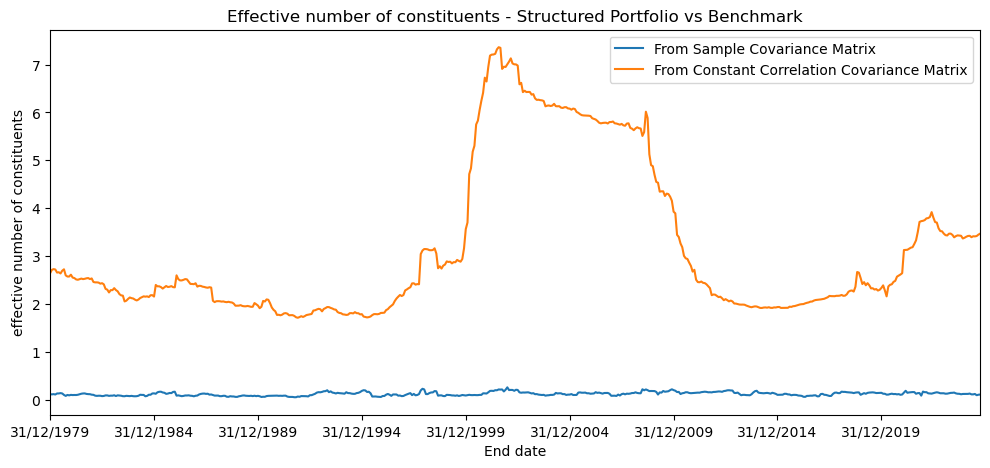

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(results_df['end_date'], results_df['enc_sample'], label='From Sample Covariance Matrix')
plt.plot(results_df['end_date'], results_df['enc_constant_corr'], label='From Constant Correlation Covariance Matrix')
plt.legend()
plt.xlabel('End date')
plt.ylabel('effective number of constituents')
plt.title('Effective number of constituents - Structured Portfolio vs Benchmark')
plt.xlim(results_df['end_date'].iloc[0], results_df['end_date'].iloc[-1])
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # Show only 10 ticks on x-axis
plt.show()

The first graph shows the effective number of constituents over time for portfolios built using the sample covariance matrix versus the constant correlation covariance matrix. It is evident that the portfolios constructed with the constant correlation covariance matrix achieve a significantly higher effective number of constituents compared to those built with the sample covariance matrix. This indicates that the structured covariance matrix approach enhances diversification, as it spreads the portfolio weight across a broader set of assets, reducing concentration risks.

The second graph demonstrates the leverage over time for the two portfolio construction approaches. Portfolios utilizing the constant correlation covariance matrix require much lower leverage compared to those using the sample covariance matrix. This is particularly advantageous as it reduces the reliance on borrowing or the use of derivatives to achieve desired returns, thereby lowering associated risks.

By using a structured covariance matrix estimate, such as the constant correlation approach:

* Diversification improves, as evidenced by the higher effective number of constituents.
* Portfolio leverage decreases, contributing to more robust and stable portfolio management.

6. Calculate the monthly returns of the two GMV portfolios from January 1972 to September 2024.
(The data from Jan. 1970 to Jan. 1972 is used to estimate the first covariance matrices.)

In [16]:
sample_weights_df = pd.DataFrame(sample_weights, columns=returns.columns)
constant_corr_weights_df = pd.DataFrame(constant_corr_weights, columns=returns.columns)
sample_weights_df.index = returns.index[window_size-1::step_size]
constant_corr_weights_df.index = returns.index[window_size-1::step_size]

In [17]:
sample_weights = sample_weights_df.iloc[:-1].reset_index(drop=True)
constant_corr_weights = constant_corr_weights_df.iloc[:-1].reset_index(drop=True)

In [18]:
returns = returns.loc['31/01/1980':].reset_index(drop=True)

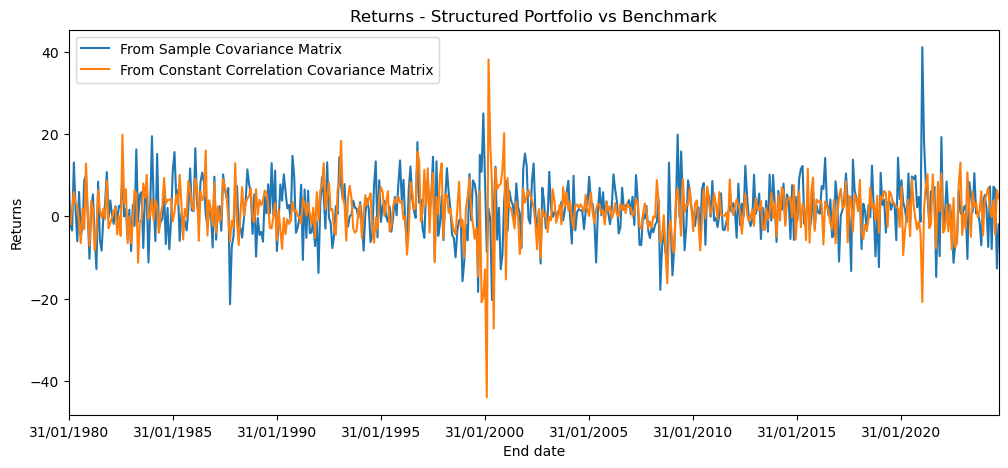

In [19]:
sample_returns = np.sum(sample_weights.values * returns.values[:len(sample_weights)], axis=1)
constant_corr_returns = np.sum(constant_corr_weights.values * returns.values[:len(constant_corr_weights)], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(results_df['end_date'].iloc[1:], sample_returns, label='From Sample Covariance Matrix')
plt.plot(results_df['end_date'].iloc[1:], constant_corr_returns, label='From Constant Correlation Covariance Matrix')
plt.legend()
plt.xlabel('End date')
plt.ylabel('Returns')
plt.title('Returns - Structured Portfolio vs Benchmark')
plt.xlim(results_df['end_date'].iloc[1], results_df['end_date'].iloc[-1])
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # Show only 10 ticks on x-axis

plt.show()

In [20]:
final_results = pd.DataFrame({})
final_results['sample_returns'] = sample_returns
final_results['constant_corr_returns'] = constant_corr_returns
final_results

,sample_returns,constant_corr_returns
0,9.827732,-0.326898
1,-2.203207,-2.093077
2,-3.461825,1.992512
3,13.073066,5.913489
4,1.594902,3.351223
...,...,...
532,-7.945392,-0.192093
533,7.186528,3.865850
534,6.612363,-4.430601
535,-12.661934,6.348132


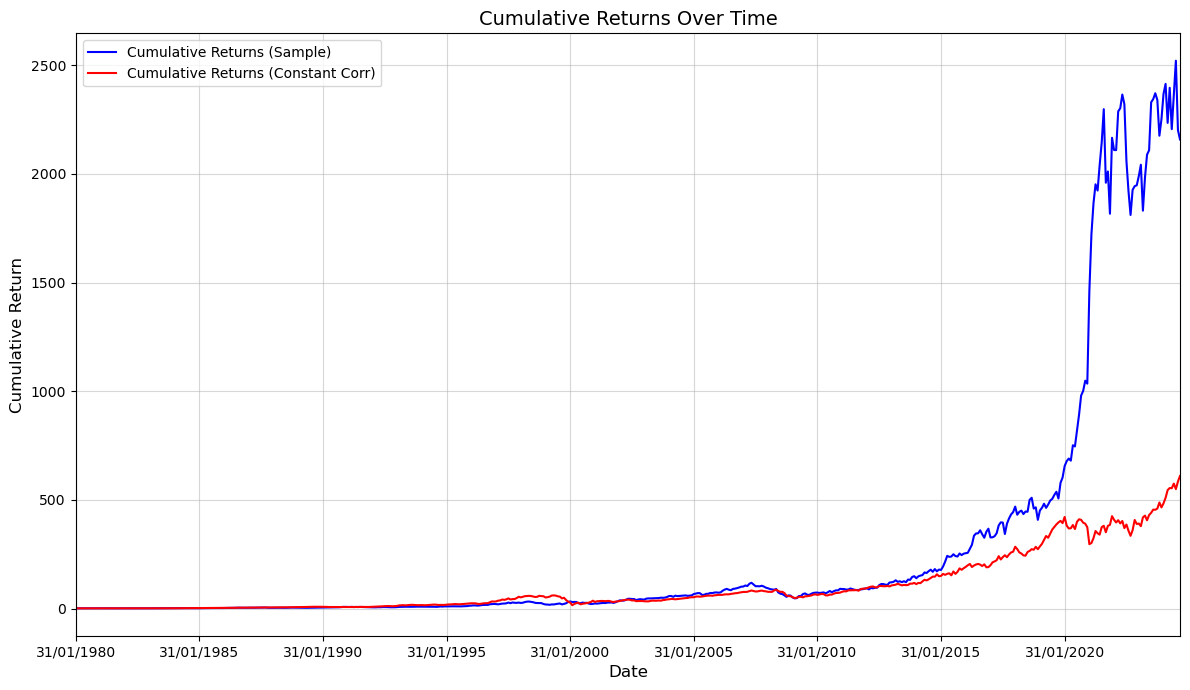

In [21]:
# Calculate cumulative returns for both columns
final_results['out_of_sample_returns_sample'] = (1 + final_results['sample_returns']/100).cumprod()
final_results['out_of_sample_returns_const_corr'] = (1 + final_results['constant_corr_returns']/100).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(12, 7))
plt.plot(results_df['end_date'].iloc[1:], final_results['out_of_sample_returns_sample'], label='Cumulative Returns (Sample)', color='blue')
plt.plot(results_df['end_date'].iloc[1:], final_results['out_of_sample_returns_const_corr'], label='Cumulative Returns (Constant Corr)', color='red')
plt.title('Cumulative Returns Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(alpha=0.5)
plt.xlim(results_df['end_date'].iloc[1], results_df['end_date'].iloc[-1])
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # Show only 10 ticks on x-axis
plt.legend()
plt.tight_layout()
plt.show()

7. Compare the volatilities of the two GMV portfolios

The returns provided in the original dataset are already annualized so we don(t need to annualized the volatility when computing it.)

In [22]:
# compute volatilities of the two portfolios
sample_volatility =  np.std(sample_returns/100)
constant_corr_volatility = np.std(constant_corr_returns/100)

print(sample_volatility)
print(constant_corr_volatility)

0.06839823629787567
0.05980716712276219


We conclude the Constant correlation approach provides a portfolio with less volatility.

# 3. Put-Call parity in Bitcoin Options

1. Import the option data

In [23]:
df = pd.read_csv('bitcoin_options.csv')
df.head(5)

,name,trade date,option_type,price (in BTC),strike_price,maturity date
0,BTC-10APR20-4750-C,2020-04-02,Call,0.319,4750,2020-04-10
1,BTC-10APR20-4750-C,2020-04-04,Call,0.295,4750,2020-04-10
2,BTC-10APR20-4750-P,2020-03-28,Put,0.015,4750,2020-04-10
3,BTC-10APR20-4750-P,2020-03-29,Put,0.027,4750,2020-04-10
4,BTC-10APR20-4750-P,2020-03-30,Put,0.010,4750,2020-04-10


2. For every pair of a trade date and a maturity date, find the twin options with this maturity date
traded on that date.

In [24]:
df_temp = df.groupby(['trade date', 'maturity date'])

twin_options = df_temp.apply(lambda group: group.pivot(index='strike_price', columns='option_type', values='price (in BTC)')).dropna()
twin_options

option_type                              Call     Put
trade date maturity date strike_price                
2017-03-03 2017-03-10    1250          0.0573  0.0298
                         1275          0.0466  0.0311
2017-03-04 2017-03-10    1200          0.0651  0.0200
                         1275          0.0376  0.0380
2017-03-05 2017-03-10    1375          0.0153  0.0859
...                                       ...     ...
2024-02-10 2024-02-10    46250         0.0250  0.0001
                         46500         0.0175  0.0001
                         46750         0.0125  0.0001
                         47000         0.0085  0.0001
                         47250         0.0031  0.0001

[2489 rows x 2 columns]

3. r each pair of twin options, calculate the call-put price spread 𝐶 − 𝑃 in BTC.

In [25]:
twin_options['Spread'] = twin_options[' Call'] - twin_options[' Put']
twin_options

option_type                              Call     Put  Spread
trade date maturity date strike_price                        
2017-03-03 2017-03-10    1250          0.0573  0.0298  0.0275
                         1275          0.0466  0.0311  0.0155
2017-03-04 2017-03-10    1200          0.0651  0.0200  0.0451
                         1275          0.0376  0.0380 -0.0004
2017-03-05 2017-03-10    1375          0.0153  0.0859 -0.0706
...                                       ...     ...     ...
2024-02-10 2024-02-10    46250         0.0250  0.0001  0.0249
                         46500         0.0175  0.0001  0.0174
                         46750         0.0125  0.0001  0.0124
                         47000         0.0085  0.0001  0.0084
                         47250         0.0031  0.0001  0.0030

[2489 rows x 3 columns]

4. For every pair of a trade date and a maturity date with at least 2 pairs of twin options available,
regress the price spreads of twin options on the strike, and calculate the R-squared. Comment
on the distribution of R-squareds

count    408.000000
mean       0.966420
std        0.071230
min        0.338083
25%        0.971709
50%        0.991254
75%        0.997785
max        1.000000
Name: R-squared, dtype: float64


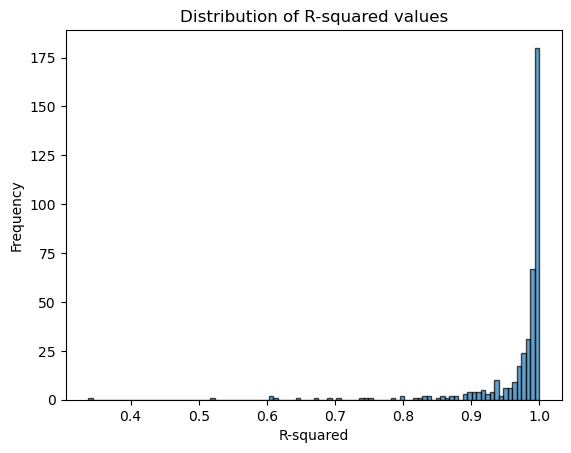

In [26]:
twin_options['Group Size'] = twin_options.groupby(['trade date', 'maturity date']).transform('size')
twin_options = twin_options[twin_options['Group Size'] > 1]

grouped = twin_options.groupby(['trade date', 'maturity date'])

r_squared_results = {}
for name, group in grouped:
    
    strikes = []
    for tuple in group.index:
        strikes.append(tuple[2])
    strikes = np.array(strikes).reshape(-1, 1)
    y = group['Spread'].values

    # Perform linear regression
    model = LinearRegression().fit(strikes, y)

    # Calculate R-squared
    r_squared = model.score(strikes, y)

    r_squared_results[name] = r_squared

# Convert the results to a DataFrame for analysis
r_squared_df = pd.DataFrame.from_dict(r_squared_results, orient='index', columns=['R-squared'])

# Comment on the distribution of R-squared values
distribution_stats = r_squared_df['R-squared'].describe()
print(distribution_stats)

# Optionally, visualize the distribution
import matplotlib.pyplot as plt
plt.hist(r_squared_df['R-squared'], bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of R-squared values')
plt.xlabel('R-squared')
plt.ylabel('Frequency')
plt.show()


The R squared being concentrated between 0.9 and 1 show that the regression of the spreads by the strikes is significantly relevant.

5. How many twin options at the minimum do we need to calculate the standard error of the
intercept? Report the number of pairs of a trade date and a maturity date for which this
condition is satisfied.

In order to calculate the standard error of the intercept, the residuals are a key point. Indeed, we want to assess if the estimation errors are important using our regression. In doing so, if the variance of the residuals is high, there will be a high error in the prediction of the model.

 

When we want to calculate the variance of the residuals, we use the following function


$$

\hat{\sigma}^2_{\epsilon} = \frac{1}{T - K - 1} \sum_{t=1}^{T} \hat{\epsilon}_t^2

$$

 

With

 

$$

\hat{\epsilon}_t = \text{fitted residuals}

$$

 

$$

K + 1 = \text{number of regressors, including the intercept}

$$

 

Basically, we understand from this formula that we need T-K-1 > 0

 

Our linear regression only regresses the strike price, so K = 1

So we need T-2>0, only achievable if T >= 3


In [27]:
# Group the data by 'trade date' and 'maturity date'
grouped = twin_options.groupby(['trade date', 'maturity date'])

# Loop through each group
counter = 0
for name, group in grouped:

    if len(group) >= 3:

        counter += 1
 
print("We have", counter, "pairs complying with T>=3")

We have 385 pairs complying with T>=3


6. What must be the intercept in the regression if put-call parity holds? For the selected pairs
of a trade date and a maturity date, test if the intercept is equal to the theoretical value, and
report the percentage of pairs for which the null hypothesis of equality is not rejected.

The intercept should be equal to 1 because we performed a regression of the spread (C - P) against the strike price (K), with the Call (C) and Put (P) prices expressed in Bitcoin index points. This aligns with the theoretical relationship derived from put-call parity in options pricing, where the difference between the call and put prices equals the difference between the asset price and the strike price, assuming no arbitrage opportunities.

In [ ]:
twin_options = twin_options[twin_options['Group Size'] > 2]

grouped = twin_options.groupby(['trade date', 'maturity date'])

results = []
alphas = [0.01, 0.05, 0.1]  # Significance level
final_results = []

for alpha in alphas:
    for name, group in grouped:
        # Extract strikes and spreads
        strikes = np.array([idx[2] for idx in group.index]).reshape(-1, 1)
        y = group['Spread'].values

        # Perform linear regression
        model = LinearRegression().fit(strikes, y)
        intercept = model.intercept_
        n = len(y)

        # Compute standard error of the intercept
        residuals = y - model.predict(strikes)
        residual_sum_of_squares = np.sum(residuals**2)
        std_error = np.sqrt(residual_sum_of_squares / (n - 2)) * np.sqrt(1 / n + np.mean(strikes)**2 / np.sum((strikes - np.mean(strikes))**2))

        # Perform t-test for the intercept
        t_stat = (intercept - 1) / std_error
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 2))  # Two-tailed test

        # Append result (null hypothesis not rejected if p-value > alpha)
        results.append(p_value > alpha)

    # Calculate percentage of pairs where null hypothesis is not rejected
    percentage_not_rejected = np.mean(results) * 100

    print('Significance level:', alpha)
    print(f"Percentage of pairs where null hypothesis is not rejected: {percentage_not_rejected:.2f}%")



Significance level: 0.01
Percentage of pairs where null hypothesis is not rejected: 93.77%
Significance level: 0.05
Percentage of pairs where null hypothesis is not rejected: 88.05%
Significance level: 0.1
Percentage of pairs where null hypothesis is not rejected: 83.12%
